In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Activation, GlobalAveragePooling2D, Dense, Dropout
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score, confusion_matrix
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [2]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [3]:
!nvidia-smi

Thu Jan 27 15:34:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-SXM2...  On   | 00000000:3E:00.0 Off |                    0 |
| N/A   29C    P0    40W / 300W |    363MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-SXM2...  On   | 00000000:B1:00.0 Off |                    0 |
| N/A   

## 1. 下載simpson dataset

In [ ]:
#!unzip -qq NPP_Parsing_300.zip

In [ ]:
# import os
# from PIL import Image

# data_dir = './'
# data_path = os.path.join(data_dir, '')
# data_resize_800_dir = './NPP_Parsing_600/'

# #for dir in os.listdir(data_path):
# # for img in os.listdir(data_path):
# image = Image.open(os.path.join(data_dir,'AHS25-WC.jpg'))
# new_image = image.resize((600, 600))
# new_image.save(os.path.join(data_resize_800_dir,'AHS25-WC.jpg'))


In [ ]:
# #將圖片轉換成陣列格式
# image1 = cv2.imread('NPP_Parsing_300/AC1Q8-WT.jpg')
# image2 = cv2.imread('NPP_Parsing_300/AC1Q8-WC.jpg')
# image1 =cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
# image2 =cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
# imagePD = np.concatenate((image1,image2))
# print(imagePD.shape)
# #畫出圖片
# plt.imshow(imagePD)

In [ ]:
# import os
# from PIL import Image

# def imgConcat(img_c,img_t):
#     image1 = cv2.imread('./NPP_Parsing_800/' + img_c)
#     image2 = cv2.imread('./NPP_Parsing_800/' + img_t)
#     image1 =cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
#     image2 =cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
#     imagePD = np.concatenate((image1,image2))    
#     im = Image.fromarray(imagePD)
#     im.save(os.path.join('./img_ct/', img_t[:-4]+'_CT.jpg'))
# #     im.save(os.path.join('./img_ct/', 'test.jpg'))

In [ ]:
# train_data['img_c'][599]

In [ ]:
# train_data['img_t'][599]

In [ ]:
# for i in range(len(train_data)):    
#     imgConcat(train_data['img_c'][i],train_data['img_t'][i])
#     print(i)

## 3. 將圖片路徑以及標籤個存取在陣列裡面

In [ ]:
# # 圖片大小
# # Shape_W =  800
# # Shape_H =  1600
# Shape = 800
# # Batch size
# batch_size =  8 #16
# # 訓練集路徑
# Trainloc = 'NPP_Parsing_800/'
# # # 測試集路徑
# Testloc = 'NPP_Parsing_800/'

# #Trainloc = 'img_c/'
# # Trainloc = 'img_ct/'
# # 測試集路徑
# #Testloc = 'img_ct/'
# #讀入CSV
# train_data = pd.read_csv("CT.csv", low_memory=False)

# train_data['img_ct'] = train_data['img_t'].str.slice(0,-4)+ '_CT.jpg'
# train_data
# train_data['pred'] = train_data['pred1'].astype(str) + train_data['pred2'].astype(str) + train_data['pred3'].astype(str)
# train_data

In [4]:
# 圖片大小
# Shape_W =  800
# Shape_H =  1600
#Shape = 600
Shape = 300
# Batch size
batch_size = 10 #16#32 #10
# 訓練集路徑
Trainloc = 'NPP_Parsing_300/'
# # 測試集路徑
Testloc = 'NPP_Parsing_300/'

#Trainloc = 'img_c/'
# Trainloc = 'img_ct/'
# 測試集路徑
#Testloc = 'img_ct/'
#讀入CSV
train_data = pd.read_csv("train_val.csv", low_memory=False)


label = {'CF':0, 
         'TFT':1}

label1 = {'上':0, 
         '下':1}

label2 = {'玻璃屑':0,
         '透明異物':1,
         '黑色異物':2, 
         '金屬異物':3}

train_data['pred3'] = train_data['pred3'].map(label2).values
train_data['pred2'] = train_data['pred2'].map(label1).values
train_data['pred1'] = train_data['pred1'].map(label).values


# train_data['img_ct'] = train_data['img_t'].str.slice(0,-4)+ '_CT.jpg'
# train_data
train_data['pred'] = train_data['pred1'].astype(str) + train_data['pred2'].astype(str) + train_data['pred3'].astype(str)
train_data

,pred1,pred2,pred3,img_c,img_t,pred
0,0,1,3,ZIFT26-WC.jpg,ZIFT26-WT.jpg,013
1,0,1,3,ZIFT27-WC.jpg,ZIFT27-WT.jpg,013
2,0,1,3,ZIFT13-WC.jpg,ZIFT13-WT.jpg,013
3,0,1,3,ZIFT7-WC.jpg,ZIFT7-WT.jpg,013
4,0,1,3,ZIFT3-WC.jpg,ZIFT3-WT.jpg,013
...,...,...,...,...,...,...
795,1,1,0,AJ2T37-WC.jpg,AJ2T37-WT.jpg,110
796,0,1,0,AJ3Q24-WC.jpg,AJ3Q24-WT.jpg,010
797,1,1,0,AJ4Q22-WC.jpg,AJ4Q22-WT.jpg,110
798,0,1,0,AKBT11-WC.jpg,AKBT11-WT.jpg,010


In [ ]:
# train_data= pd.concat([train_data_T,train_data_C],axis=1)

In [ ]:
# train_data['img_t']
# del df['pred2']
# del df['pred3']

In [5]:
df = train_data.copy()
df
data_list = df

# 二、資料預處理

## 1. Train Test split

In [6]:
from sklearn.model_selection import train_test_split

train_list, test_list = train_test_split(data_list,
                      test_size=0.2,
                      random_state= 42,
                      stratify=data_list['pred'].values,
                      shuffle = True)
print(len(train_list),len(test_list))

640 160


## 2. 資料擴增Data Augmentation

In [7]:
#from tensorflow.keras.applications import EfficientNetB3
#from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input

## 3. 將要訓練的資料輸入進keras data generator裏面

In [ ]:
# # y_pred = ['pred1','pred2','pred3']
# x_c='img_ct'
# y_pred='pred'
# train_datagen = ImageDataGenerator() # 訓練集資料擴增，設計你們自己資料擴增的選擇，記得rescale很重要

# train_gen = train_datagen.flow_from_dataframe(
#     dataframe = train_list,
#     directory = Trainloc,
#     x_col = x_c,
#     y_col = y_pred,
#     color_mode = 'rgb',
#     target_size = (Shape_W,Shape_H),
#     batch_size = batch_size,
#     shuffle = True,
#     preprocessing_function=preprocess_input,
#     class_mode = 'categorical')

# test_datagen = ImageDataGenerator()  # 驗證集資料擴增，記得驗證集是否會需要資料擴增，然後有什麼必須要跟train_datagen一樣的
# test_gen = test_datagen.flow_from_dataframe(
#     dataframe = test_list,
#     directory = Trainloc,
#     x_col = x_c,
#     y_col = y_pred,
#     color_mode = 'rgb',
#     target_size = (Shape_W,Shape_H),
#     batch_size = batch_size,
#     shuffle = False,
#     preprocessing_function=preprocess_input,
# #     class_mode="raw",
# #     class_mode = 'multi_output',
# #     class_mode = 'categorical',
#     class_mode = 'categorical')

In [8]:
labelinput = dict(zip(df['pred'].unique(), range(len(df['pred'].unique()))))
labelinput

{'013': 0,
 '113': 1,
 '003': 2,
 '103': 3,
 '112': 4,
 '102': 5,
 '012': 6,
 '002': 7,
 '111': 8,
 '011': 9,
 '001': 10,
 '101': 11,
 '010': 12,
 '110': 13,
 '000': 14,
 '100': 15}

In [9]:
#glow
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size, size, labelinput, Shuffle=False): #Shuffle=False
        self.df = df.copy()
        # self.path = path
        self.batch_size = batch_size
        self.size = size
        self.Shuffle = Shuffle
        self.labelinput = labelinput   # labelinput = {'defect1':1,'defeact2':2, etc}
        self.num_classes = len(labelinput)
        # self.n = len(path)
        self.n = len(self.df)
        self.on_epoch_end()

    def __len__(self):  
        remainder = len(self.df) % self.batch_size
        if (remainder != 0 ):
            remainder = 1
        return int(np.floor(len(self.df) / self.batch_size)) + remainder
        
# # [(img_c_path, img_t_path, label)]
    def __getitem__(self, idx):
        path_batch = self.df.iloc[idx *self.batch_size:(idx + 1) * self.batch_size, 3:6].to_numpy()
        X,y = self.__generator(path_batch)

        return X,y
    
    def on_epoch_end(self):
        if self.Shuffle == True:
            self.df = shuffle(self.df).reset_index(drop=True)
    
    def __generator(self, path_batch):
        concat_images = list()
        labels = list()

        for img_c_path, img_t_path, label in path_batch:
            img_c = tf.keras.preprocessing.image.load_img(Trainloc + img_c_path,
                                                        grayscale=False, 
                                                        color_mode='rgb', 
                                                        target_size=(self.size,self.size))
            img_t = tf.keras.preprocessing.image.load_img(Trainloc + img_t_path, 
                                                        grayscale=False, 
                                                        color_mode='rgb', 
                                                        target_size=(self.size,self.size))
            
            
            img_c =  tf.keras.preprocessing.image.img_to_array(img_c)
            img_t =  tf.keras.preprocessing.image.img_to_array(img_t)
            # efficientB7 preprocessing, 如果是自己刻模型那這邊要改掉
            img_c = tf.keras.applications.efficientnet.preprocess_input(img_c)
            img_t = tf.keras.applications.efficientnet.preprocess_input(img_t)
            # 將圖沿著w dim concat起來
            img = tf.concat([img_c, img_t], axis = 1)
            # 將圖沿著c dim concat起來
            # img = tf.concat([img_c, img_t], axis = 2)
            concat_images.append(img)
            labels.append(self.labelinput[label])
        
        
        return np.asarray(concat_images),np.asarray(labels)

# 三、載入預訓練模型
Use `ResNet50` for Transfer learning

## 1. 讀入模型

In [12]:
#B7
from tensorflow.keras.layers import Input, Flatten

from tensorflow.keras.applications import EfficientNetB7
#from tensorflow.keras.applications import EfficientNetB3
with strategy.scope():

    #pre_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(Shape, Shape, 3)) 
    pre_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(Shape, Shape, 3)) 

    # Do GlobalAveragePooling2D
    x = GlobalAveragePooling2D()(pre_model.output)

    #x = Flatten()(x)
    # Dense layer
    x = Dense(Shape, activation='relu')(x)


    #Output layer
    # label = Dense(label.shape[-1], activation='sigmoid', name='label')(x)
    # label1 = Dense(label1.shape[-1], activation='sigmoid', name='label1')(x)
    # label2 = Dense(label2.shape[-1], activation='softmax', name='label2')(x)

    # label = Dense(len(label), activation='sigmoid', name='label')(x)
    # label1 = Dense(len(label1), activation='sigmoid', name='label1')(x)
    # label2 = Dense(len(label2), activation='softmax', name='label2')(x)

#     pred_ct = Dense(len(label), activation='softmax', name='pred_ct')(x)
    pred_ct = Dense(len(labelinput), activation='softmax', name='pred_ct')(x)

# set up a model structure#
# model = Model(inputs=pre_model.inputs, outputs= [label, label1, label2])

    model = Model(inputs=pre_model.inputs, outputs= pred_ct)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    loss_fn = keras.losses.SparseCategoricalCrossentropy()

    model.compile(optimizer = optimizer, 
                loss = loss_fn,
                metrics='accuracy'
             )
    
model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
# #B7
# from tensorflow.keras.layers import Input, Flatten

# from tensorflow.keras.applications import EfficientNetB3 
# from tensorflow.keras.applications import ResNet50 
# # with strategy.scope():

# #     pre_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(Shape_W, Shape_H, 3)) 

# #     # Do GlobalAveragePooling2D
# #     x = GlobalAveragePooling2D()(pre_model.output)

# #     x = Flatten()(x)
# #     # Dense layer
# #     x = Dense(800, activation='relu')(x)

# pre_model_c = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(800, 800, 3)) 

# # Do GlobalAveragePooling2D
# x1 = GlobalAveragePooling2D()(pre_model_c.output)


# pre_model_t = ResNet50(weights='imagenet', include_top=False, input_shape=(800, 800, 3)) 

# # Do GlobalAveragePooling2D
# x2 = GlobalAveragePooling2D()(pre_model_t.output)

# concatted = tf.keras.layers.Concatenate(axis=-1)([x1, x2])

# x = Dense(800, activation='relu')(x)

# pred_ct = Dense(len(label), activation='softmax', name='pred_ct')(x)


# model = Model(inputs=[pre_model_c.inputs,pre_model_t.inputs], outputs= pred_ct)
    
# model.summary()

## 2. 決定要Fine tune Freeze的layer
這個要判斷今天的資料集狀況再決定是否要對預訓練模型的layer做Freezing

In [13]:
# model.trainable = False #每一層全打開是 fine tune  False= 全凍,不學用原本的
model.trainable = True #每一層全打開是 fine tune  True= 全部自己來

# 我們可以選擇我們要finetune的block
#從layer得名稱中，找到我們想要凍結前的layer名稱，並將這些前面的layer給Freeze起來

# for layer in model.layers[:-10]:
#     layer.trainable = False
#     print(layer.name)


In [ ]:
# model.trainable = True #每一層全打開是 fine tune

# for layer in model.layers:
#     if layer.name == 'block4a_project_conv':
#         break
#     layer.trainable = False
#     print(layer.name)

## 3. 決定 Loss function 、Optimizer

In [ ]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
# loss_fn = keras.losses.SparseCategoricalCrossentropy()

# me=['accuracy', "Precision", "Recall"]
# model.compile(optimizer = optimizer, 
#                loss={'label': loss_fn,
#                      'label1': loss_fn,
#                      'label2': loss_fn},
#               metrics={'label':'accuracy',
#                      'label1': 'accuracy',
#                      'label2': 'accuracy'}
# #          loss = 'sparse_categorical_crossentropy',
# #        loss = 'categorical_crossentropy', 
# #      loss = 'binary_crossentropy',
# #       metrics=['accuracy', "Precision", "Recall"]
#              )

In [ ]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# loss_fn = keras.losses.SparseCategoricalCrossentropy()

# model.compile(optimizer = optimizer, 
#                 loss = loss_fn,
#                 metrics='accuracy'
#              )

## 4. 設定 Callbacks Function

In [14]:
model_name = 'B7_CT_300_0127_01'
model_dir = './model-logs/' + model_name
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# save model
modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = tf.keras.callbacks.ModelCheckpoint(modelfiles,
                          monitor='val_accuracy',
                          save_best_only=True)
# set earlystop
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                        patience=10,
                        verbose=1)



from tensorflow.keras.callbacks import ReduceLROnPlateau
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.6,
    patience=10,
    verbose=1,
    mode="auto",
    #min_delta=0.0001,
    min_delta=1e-6, #0.000001,
    cooldown=0,
    min_lr=0
)

callbacks_list = [model_mckp,earlystop,reduceLR]
#callbacks_list = [model_mckp]

## 5. 開始訓練囉！

In [ ]:
# # Open a strategy scope.
# with strategy.scope():
#   # Everything that creates variables should be under the strategy scope.
#   # In general this is only model construction & `compile()`.
# #     model = Model(Model(inputs=pre_model.inputs, outputs= pred_ct))
#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), 
#                 loss = keras.losses.SparseCategoricalCrossentropy(),
#                 metrics='accuracy')

In [ ]:
!nvidia-smi

In [ ]:
num_epochs =  100
#glow
traingen = DataGenerator(train_list,
                         batch_size=batch_size, size= Shape, labelinput=labelinput)

valgen = DataGenerator(train_list,
                       batch_size=batch_size, size= Shape, labelinput=labelinput)


history = model.fit(traingen,
          validation_data=valgen,
          callbacks=callbacks_list, 
          epochs=num_epochs)

In [ ]:
# traingen.class__indice

# 四、查看模型訓練結果

In [ ]:
training_loss, val_loss = history.history['loss'], history.history['val_loss']

plt.title('Loss')
plt.plot(training_loss, label='Train')
plt.plot(val_loss, label='Val')
plt.legend()
plt.show()

training_acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

plt.title('ACC')
plt.plot(training_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend()
plt.show()

# 五、測試模型
在訓練好模型後，我們一定會拿測試集來測試一下我們訓練模型的好壞

現在就是要使用kaggle_simpson_testset來進行預測

## 1. 將預測的資料集讀取下來，並轉換成dataframe形式
** 會全部先設定class為1是因為我們不知道標籤，所以先預設為1 **

In [ ]:
# #讀取圖片與 Label
# data_dir = './'
# testing_dir_path = os.path.join(data_dir, 'Dataset/test')
# test_df = pd.DataFrame({'file_path':[str(id)+'.jpg' for id in range(3001)],'class':1}) 
# test_df

## 2. 將測試集的dataframe放入keras data generator中

In [ ]:
# tgen = ImageDataGenerator()
# test_gen = tgen.flow_from_dataframe(dataframe = test_df,
#                                     directory = Testloc,
#                                     x_col = 'file_path',
#                                     y_col = 'class',
#                                     color_mode='rgb',
#                                     target_size = (Shape,Shape),
#                                     batch_size = batch_size,
#                                     class_mode = None,
#                                     shuffle=False,
#                                     preprocessing_function=preprocess_input)

# y_pred = model.predict(test_gen).argmax(-1)

In [ ]:
# y_pred

In [ ]:
# test_df

In [ ]:
# test_df['class'] =y_pred
# test_df

# 六、評估模型

In [ ]:
# !unzip -qq NPP_Parsing_test.zip

In [ ]:
# import numpy as np
# import pandas as pd
# import cv2
# import matplotlib.pyplot as plt
# import os
# from PIL import Image

# #圖片Resize
# resize = 300
# data_dir = './NPP_Parsing_test/'
# data_path = os.path.join(data_dir, '')
# data_resize_800_dir = './NPP_Parsing_800/'
# data_resize_600_dir = './NPP_Parsing_600/'
# data_resize_400_dir = './NPP_Parsing_400/'
# data_resize_300_dir = './NPP_Parsing_300_test/'
# data_resize_100_dir = './NPP_Parsing_100/'

# #for dir in os.listdir(data_path):
# for img in os.listdir(data_path):
#     if (img[-3:] == "jpg"):
#         image = Image.open(os.path.join(data_dir,img))
#         new_image = image.resize((resize, resize))
#         new_image.save(os.path.join(data_resize_300_dir,img))

In [ ]:
!nvidia-smi

In [15]:
#讀入CSV
test_data = pd.read_csv("test.csv", low_memory=False)
# test_data = pd.read_csv("train_val.csv", low_memory=False)
label = {'CF':0, 
         'TFT':1}

label1 = {'上':0, 
         '下':1}

label2 = {'玻璃屑':0,
         '透明異物':1,
         '黑色異物':2, 
         '金屬異物':3}

test_data['pred'] = ""
test_data['pred3_orig'] = test_data['pred3']
test_data['pred2_orig'] = test_data['pred2']
test_data['pred1_orig'] = test_data['pred1']

test_data['pred3'] = test_data['pred3'].map(label2).values 
test_data['pred2'] = test_data['pred2'].map(label1).values
test_data['pred1'] = test_data['pred1'].map(label).values


# test_data['img_ct'] = test_data['img_t'].str.slice(0,-4)+ '_CT.jpg'
test_data['pred'] = test_data['pred1'].astype(str) + test_data['pred2'].astype(str) + test_data['pred3'].astype(str)
test_data

,pred1,pred2,pred3,img_c,img_t,pred,pred3_orig,pred2_orig,pred1_orig
0,0,1,0,ACJ2-WC.jpg,ACJ2-WT.jpg,010,玻璃屑,下,CF
1,1,1,0,AB2Q29-WC.jpg,AB2Q29-WT.jpg,110,玻璃屑,下,TFT
2,1,0,0,AB1Q36-WC.jpg,AB1Q36-WT.jpg,100,玻璃屑,上,TFT
3,1,1,0,ABT9-WC.jpg,ABT9-WT.jpg,110,玻璃屑,下,TFT
4,1,1,0,ABST27-WC.jpg,ABST27-WT.jpg,110,玻璃屑,下,TFT
...,...,...,...,...,...,...,...,...,...
315,0,1,3,ZFH18-WC.jpg,ZFH18-WT.jpg,013,金屬異物,下,CF
316,0,1,3,ZFH10-WC.jpg,ZFH10-WT.jpg,013,金屬異物,下,CF
317,1,1,3,ZFH6-WC.jpg,ZFH6-WT.jpg,113,金屬異物,下,TFT
318,1,1,3,ZFG4-WC.jpg,ZFG4-WT.jpg,113,金屬異物,下,TFT


In [16]:
testloc ='NPP_Parsing_300_test/'
# testloc ='NPP_Parsing_300/'


class DataGenerator_test(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size, size, labelinput, Shuffle=False): #Shuffle=False
        self.df = df.copy()
        # self.path = path
        self.batch_size = batch_size
        self.size = size
        self.Shuffle = Shuffle
        self.labelinput = labelinput   # labelinput = {'defect1':1,'defeact2':2, etc}
        self.num_classes = len(labelinput)
        # self.n = len(path)
        self.n = len(self.df)
        self.on_epoch_end()

    def __len__(self):
        remainder = len(self.df) % self.batch_size
        if (remainder != 0 ):
            remainder = 1
        return int(np.floor(len(self.df) / self.batch_size)) + remainder 
        
# # [(img_c_path, img_t_path, label)]
    def __getitem__(self, idx):
        path_batch = self.df.iloc[idx *self.batch_size:(idx + 1) * self.batch_size, 3:6].to_numpy()
        X,y = self.__generator(path_batch)

        return X,y
    
    def on_epoch_end(self):
        if self.Shuffle == True:
            self.df = shuffle(self.df).reset_index(drop=True)
    
    def __generator(self, path_batch):
        concat_images = list()
        labels = list()

        for img_c_path, img_t_path, label in path_batch:
            img_c = tf.keras.preprocessing.image.load_img(testloc + img_c_path,
                                                        grayscale=False, 
                                                        color_mode='rgb', 
                                                        target_size=(self.size,self.size))
            img_t = tf.keras.preprocessing.image.load_img(testloc + img_t_path, 
                                                        grayscale=False, 
                                                        color_mode='rgb', 
                                                        target_size=(self.size,self.size))
            
            
            img_c =  tf.keras.preprocessing.image.img_to_array(img_c)
            img_t =  tf.keras.preprocessing.image.img_to_array(img_t)
            # efficientB7 preprocessing, 如果是自己刻模型那這邊要改掉
            img_c = tf.keras.applications.efficientnet.preprocess_input(img_c)
            img_t = tf.keras.applications.efficientnet.preprocess_input(img_t)
            # 將圖沿著w dim concat起來
            img = tf.concat([img_c, img_t], axis = 1)
            #img = tf.concat([img_c, img_t], axis = 2) #MIC
            concat_images.append(img)
            labels.append(self.labelinput[label])
        
        
        return np.asarray(concat_images),np.asarray(labels)

In [17]:
def model_prediction(test_data, batch_size, model_name, labelinput_test):
    model_folder = './model-logs'
    model_file = "basic_model-best-model.h5"
    model_path = os.path.join(model_folder, model_name, model_file)
   
    pred_generator = DataGenerator_test(test_data,
                       batch_size=batch_size, size= Shape, labelinput=labelinput)
    
    model = load_model(model_path)
    print(f'Model is {model_name}.')

    result = model.predict(pred_generator)
#     print(pred_generator.filenames)
    return result

In [18]:
#model_list = ['B7_CT_300_0126_01']  
# model_list = ['B3_CT_300_0125_M_03']
model_list = [model_name]

all_train_pred = {}
all_test_pred = {}
all_class = {}

for each in model_list:
    #print('model:' + each)
    all_test_pred[each] = model_prediction(test_data, batch_size, each, labelinput) #利用驗證集預測
#     all_test_pred[each] = model_prediction(train_data, 1, each, labelinput) #利用驗證集預測
    K.clear_session()
    

Model is B7_CT_300_0126_01.


In [21]:
# test_data.head(5)
# test_data.head(5)
print(model_name)
len(test_data)

B7_CT_300_0127_01


320

In [22]:
#model_name = "B7_CT_300_0126_01"
len(all_test_pred[model_name].argmax(-1))

320

In [23]:
all_test_pred[model_name][0]

array([8.1492014e-02, 9.4362053e-07, 1.5707784e-06, 3.1867867e-07,
       2.3146333e-08, 3.7759307e-07, 1.1946993e-04, 2.4761068e-08,
       6.6227287e-08, 5.9592430e-06, 1.1739951e-06, 5.5334281e-06,
       9.1835809e-01, 9.3663220e-06, 3.9953366e-06, 1.0716724e-06],
      dtype=float32)

In [24]:
num_class = len(labelinput)

# 建立一個空間，將模型預測的放進去，以便後面 vote 用
test_vote = np.zeros((len(test_data), num_class)) #np.zeros((資料的筆數, 類別數量))
test_vote.shape

for each in model_list:
    test_pred = all_test_pred[each].argmax(-1) # 從每一筆資料取出最大值
    test_vote += np.eye(num_class)[test_pred] #進行投票，將預測的結果先轉成 one-hot 的形式最後再加總起來

print(test_vote)
test_vote = test_vote.argmax(-1) # 將投票的最大值取出，當成最後的結果

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
test_data['pred']

In [25]:
test_data['ans'] = test_data['pred'].map(labelinput).values
test_data['pred_ans'] = test_vote

con = 0

for i in range(len(test_data)):
    if test_data.iloc[i]['ans'] == test_data.iloc[i]['pred_ans']:
        con = con + 1

print(con/len(test_data)*1.0)

labelinput_rev = {v: k for k, v in labelinput.items()}
label_rev = {v: k for k, v in label.items()}
label1_rev = {v: k for k, v in label1.items()}
label2_rev = {v: k for k, v in label2.items()}


test_data['pred_ans_pred1'] = test_data['pred_ans'].map(labelinput_rev).values
test_data['pred_ans_pred1'] = test_data.apply(lambda r: r['pred_ans_pred1'][0] ,axis = 1)
test_data['pred_ans_pred1_name'] = test_data['pred_ans_pred1'].astype(int).map(label_rev).values

test_data['pred_ans_pred2'] = test_data['pred_ans'].map(labelinput_rev).values
test_data['pred_ans_pred2'] = test_data.apply(lambda r: r['pred_ans_pred2'][1] ,axis = 1)
test_data['pred_ans_pred2_name'] = test_data['pred_ans_pred2'].astype(int).map(label1_rev).values

test_data['pred_ans_pred3'] = test_data['pred_ans'].map(labelinput_rev).values
test_data['pred_ans_pred3'] = test_data.apply(lambda r: r['pred_ans_pred3'][-1] ,axis = 1)
test_data['pred_ans_pred3_name'] = test_data['pred_ans_pred3'].astype(int).map(label2_rev).values

0.45


In [79]:
def print_pic(pic_c_cor,pic_t_cor,pic_c_err,pic_t_err):
    root_path = './NPP_Parsing_300_test/'
    pic_c_name_cor =root_path + pic_c_cor
    pic_t_name_cor =root_path + pic_t_cor
    pic_c_name_err =root_path + pic_c_err
    pic_t_name_err =root_path + pic_t_err

    image1 = cv2.imread(pic_t_name_cor)
    image2 = cv2.imread(pic_c_name_cor)
    image1 =cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
    image2 =cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
    imagePD1 = np.concatenate((image1,image2))
    
    image1 = cv2.imread(pic_t_name_err)
    image2 = cv2.imread(pic_c_name_err)
    image1 =cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
    image2 =cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
    imagePD2 = np.concatenate((image1,image2))   
    
    imagePD_compare = np.concatenate((imagePD1,imagePD2),axis = 1) 
    
    print(test_data[  (test_data["img_c"] == pic_c_cor) | (test_data["img_c"] == pic_c_err) ][["ans","pred_ans","pred3_orig","pred_ans_pred3_name","pred2_orig","pred_ans_pred2_name","pred1_orig","pred_ans_pred1_name"]])
    #print(imagePD.shape)
    #畫出圖片
    print("統一上方TFT+下方CF，左邊pred正確 / 右邊PRED錯誤")
    plt.figure(figsize=(10,10))
    plt.imshow(imagePD_compare)

In [26]:
#類別表查看
test_data[test_data["ans"] != 99 ][["ans","pred","pred3_orig","pred2_orig","pred1_orig"]].value_counts()

ans  pred  pred3_orig  pred2_orig  pred1_orig
0    013   金屬異物        下           CF            71
12   010   玻璃屑         下           CF            59
10   001   透明異物        上           CF            33
13   110   玻璃屑         下           TFT           30
1    113   金屬異物        下           TFT           26
9    011   透明異物        下           CF            23
8    111   透明異物        下           TFT           22
11   101   透明異物        上           TFT           22
4    112   黑色異物        下           TFT           16
14   000   玻璃屑         上           CF            10
2    003   金屬異物        上           CF             3
5    102   黑色異物        上           TFT            2
6    012   黑色異物        下           CF             1
7    002   黑色異物        上           CF             1
15   100   玻璃屑         上           TFT            1
dtype: int64

In [88]:
#查看誤判筆數
find_ans = 0
test_data[test_data["ans"] == find_ans ][["ans","pred_ans","pred3_orig","pred_ans_pred3_name","pred2_orig","pred_ans_pred2_name","pred1_orig","pred_ans_pred1_name"]].value_counts()

ans  pred_ans  pred3_orig  pred_ans_pred3_name  pred2_orig  pred_ans_pred2_name  pred1_orig  pred_ans_pred1_name
0    0         金屬異物        金屬異物                 下           下                    CF          CF                     46
     6         金屬異物        黑色異物                 下           下                    CF          CF                     15
     9         金屬異物        透明異物                 下           下                    CF          CF                      3
     10        金屬異物        透明異物                 下           上                    CF          CF                      3
     12        金屬異物        玻璃屑                  下           下                    CF          CF                      2
     13        金屬異物        玻璃屑                  下           下                    CF          TFT                     1
     14        金屬異物        玻璃屑                  下           上                    CF          CF                      1
dtype: int64

In [91]:
#找出誤判&正確資料
err_ans = 6
test_data[(test_data["ans"] == find_ans) & ((test_data["pred_ans"] == find_ans) | (test_data["pred_ans"] == err_ans)) ]

,pred1,pred2,pred3,img_c,img_t,pred,pred3_orig,pred2_orig,pred1_orig,ans,pred_ans,pred_ans_pred1,pred_ans_pred1_name,pred_ans_pred2,pred_ans_pred2_name,pred_ans_pred3,pred_ans_pred3_name
250,0,1,3,ZHE30-WC.jpg,ZHE30-WT.jpg,013,金屬異物,下,CF,0,6,0,CF,1,下,2,黑色異物
252,0,1,3,ZHET41-WC.jpg,ZHET41-WT.jpg,013,金屬異物,下,CF,0,6,0,CF,1,下,2,黑色異物
277,0,1,3,ZGK88-1-WC.jpg,ZGK88-1-WT.jpg,013,金屬異物,下,CF,0,6,0,CF,1,下,2,黑色異物
279,0,1,3,ZGH91-WC.jpg,ZGH91-WT.jpg,013,金屬異物,下,CF,0,6,0,CF,1,下,2,黑色異物
280,0,1,3,ZGH55-1-WC.jpg,ZGH55-1-WT.jpg,013,金屬異物,下,CF,0,6,0,CF,1,下,2,黑色異物
281,0,1,3,ZGH49-1-WC.jpg,ZGH49-1-WT.jpg,013,金屬異物,下,CF,0,6,0,CF,1,下,2,黑色異物
282,0,1,3,ZGH37-1-WC.jpg,ZGH37-1-WT.jpg,013,金屬異物,下,CF,0,6,0,CF,1,下,2,黑色異物
283,0,1,3,ZGH2-WC.jpg,ZGH2-WT.jpg,013,金屬異物,下,CF,0,6,0,CF,1,下,2,黑色異物
290,0,1,3,ZGCK2-WC.jpg,ZGCK2-WT.jpg,013,金屬異物,下,CF,0,6,0,CF,1,下,2,黑色異物
294,0,1,3,ZFV32-WC.jpg,ZFV32-WT.jpg,013,金屬異物,下,CF,0,6,0,CF,1,下,2,黑色異物


     ans  pred_ans pred3_orig pred_ans_pred3_name pred2_orig  \
222    0         0       金屬異物                金屬異物          下   
282    0         6       金屬異物                黑色異物          下   

    pred_ans_pred2_name pred1_orig pred_ans_pred1_name  
222                   下         CF                  CF  
282                   下         CF                  CF  
統一上方TFT+下方CF，左邊pred正確 / 右邊PRED錯誤


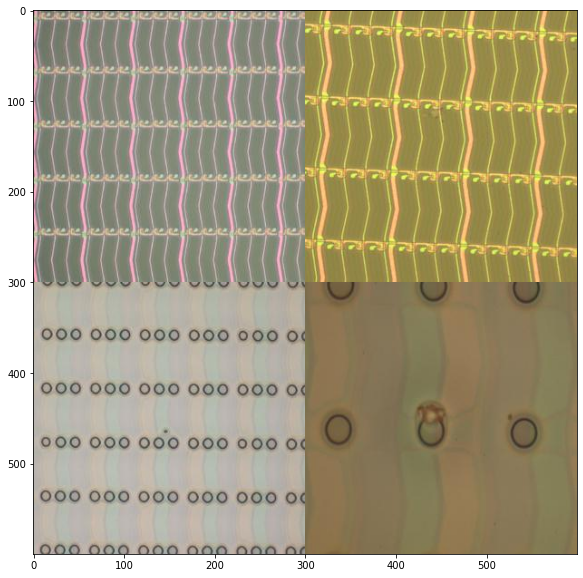

In [92]:
#顯示正確&誤判圖片
print_pic(pic_c_cor ="ZIB58-WC.jpg", pic_t_cor = "ZIB58-WT.jpg"
         ,pic_c_err = "ZGH37-1-WC.jpg", pic_t_err = "ZGH37-1-WT.jpg")  ##"ZJ2T31-WC.jpg" #"AB2Q29-WC.jpg"

In [ ]:
test_data["pred_ans"].value_counts()

In [ ]:
test_data

In [ ]:
# labelinput_test = dict(zip(test_data['pred'].unique(), range(len(test_data['pred'].unique()))))
labelinput